Trends in Dipole Field 
=====
***

Compute the trends in the axial dipole field from the PADM2M and SINT2000 models. Extract the standard deviation  as a function of the chosen time interval or window. Compare with theoretical prediction.

In [1]:
using Plots
using Distributions
using StatsBase
using DelimitedFiles
using GLM

Input PADM2M model

In [2]:
data1 = readdlm("padm2m.txt")
kyr = 1000.0;
td1 = data1[:,1] * kyr;   #  time in kyr
xd1 = data1[:,2];    # axial dipole moment
ndata1 = length(td1);
println("Number of data = ",ndata1,"  Time resolution = ",td1[2]-td1[1]," kyr")

Number of data = 2001  Time resolution = 1.0 kyr


Reverse order of arrays

In [3]:
tpadm = -reverse(td1);
padm = reverse(xd1);
dt1 = tpadm[2]-tpadm[1];

Input SINT2000 model

In [4]:
data2 = readdlm("sint2000.txt")
kyr = 1000.0;
td2 = data2[:,1] * kyr;   #  time in kyr
xd2 = data2[:,2];    # axial dipole moment
ndata2 = length(td2);
println("Number of data = ",ndata1,"  Time resolution = ",td2[2]-td2[1]," kyr")

Number of data = 2001  Time resolution = 1.0 kyr


In [5]:
tsint = -reverse(td2)
sint = reverse(xd2)
dt2 = tsint[2]-tsint[1];

Plot axial dipole versus time

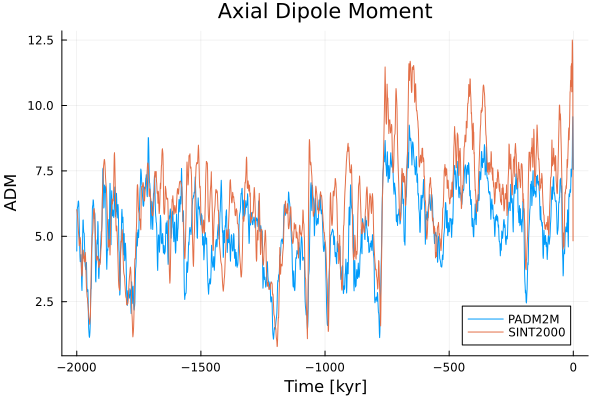

In [6]:
plot(tpadm,padm,
    xlabel="Time [kyr]",
    ylabel="ADM",
    label="PADM2M",
    title="Axial Dipole Moment",
    legend=:bottomright)
plot!(tsint,sint,label="SINT2000")

Compute mean and standard deviation

In [7]:
xbar = mean(xd1);
xmed = median(xd1)
xstd = std(xd1)
xskw = skewness(xd1)
println("PADM2M: mean = ",mean(xd1),"     s.d. = ",std(xd1))
println("SINT2000: mean = ",mean(xd2),"     s.d. = ",std(xd2))

PADM2M: mean = 5.321661604197902     s.d. = 1.480634376859384
SINT2000: mean = 6.244589391000001     s.d. = 1.9736359286409444


Define function to compute trends by method of least squares

In [8]:
function slopes(nintvl,xd,td)
    
    nsample = Int(floor(length(xd)/nintvl));
    b = zeros(nsample)
    X = ones(nintvl,2)
    X[:,2] = td[1:nintvl].-td[1];

    for i = 1 : nsample
        istart = 1 + (i-1) * nintvl;
        ols = lm(X,xd[istart:istart+nintvl-1]);  # linear fit using GLM package
        b[i] =coef(ols)[2];    # extract slope from second element of solution vector
    end

    return b
end


slopes (generic function with 1 method)

Compute trends as a function of window length for CALS10k2

In [9]:
nwindow = 105;
sk1 = zeros(nwindow);    # skewness
sd1 = zeros(nwindow);    # standard deviation
sm1 = zeros(nwindow);    # maximum trend
window1 = zeros(nwindow);

for i = 1 : nwindow
    window1[i] = i * 2.0 * dt1;
    b = slopes(i*2,padm,tpadm);
    sd1[i] = std(b)
    sm1[i] = maximum(abs.(b))
    sk1[i] = skewness(b)

end

In [10]:
nwindow = 105;
sk2 = zeros(nwindow);    # skewness
sd2 = zeros(nwindow);    # standard deviation
sm2 = zeros(nwindow);    # maximum trend
window2 = zeros(nwindow);

for i = 1 : nwindow
    window2[i] = i * 2.0 * dt2;
    b = slopes(i*2,sint,tsint);
    sd2[i] = std(b)
    sm2[i] = maximum(abs.(b))
    sk2[i] = skewness(b);

end

Now compute theoretical prediction of standard deviation

In [11]:
function theory(γ,window,D2)
    
    n = length(window)
    sigmab = zeros(n);
    w = γ * window;
    
    for i = 1 : n
        
        fw1 = w[i]^(-2) - 3 * w[i]^(-3) + 12 * w[i]^(-5);
        fw2 = exp(-w[i]) * (3*w[i]^(-3) + 12*w[i]^(-4) + 12*w[i]^(-5));
        sigmab[i] = sqrt( (24 * D2/window[i]) * (fw1 - fw2));
        
    end
    
    return sigmab
end 

theory (generic function with 1 method)

Plot standard deviation of trends

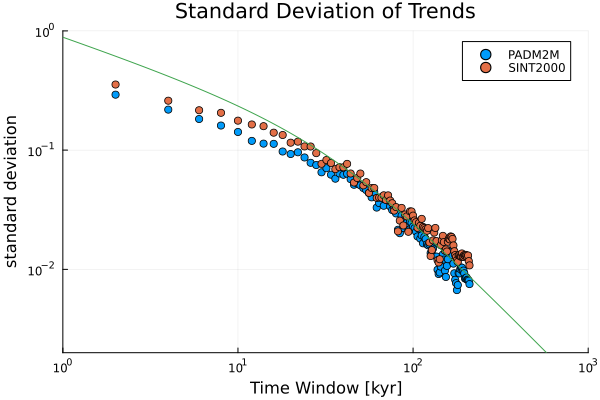

In [12]:
plot(window1,sd1,
    xlabel="Time Window [kyr]",
    ylabel="standard deviation",
    xaxis=:log10,
    yaxis=:log10,
    st=:scatter,
    label="PADM2M",
    title="Standard Deviation of Trends",
    ylim=(0.002,1),
    xlim=(1.0,1000.0))

plot!(window2,sd2,
    st=:scatter,
    label="SINT2000")

# stochastic model
D2 = 0.34;   # from M&B (2019)
γ = 0.1;

window3 = (0.1 : 0.02 : 800);
theory3 = theory(1.0*γ,window3,1.0*D2);
plot!(window3,theory3,label=nothing)

In [13]:
#savefig("PADM2M_trends_M&B.pdf")

Plot maximum trends from PADM2M and SINT2000

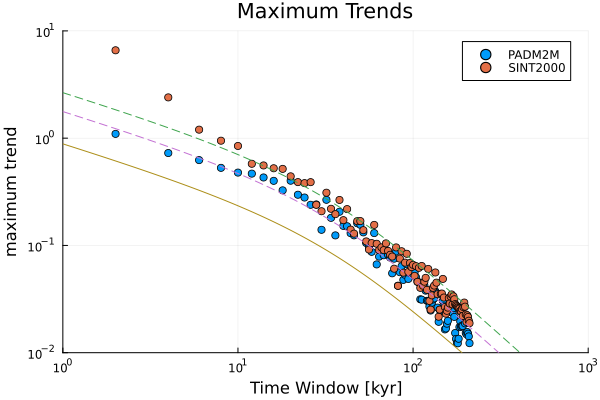

In [16]:
plot(window1,sm1,
    xlabel="Time Window [kyr]",
    ylabel="maximum trend",
    xaxis=:log10,
    yaxis=:log10,
    st=:scatter,
    xlim=(1,1000),
    ylim=(0.01,10),
    label="PADM2M",
    title="Maximum Trends")
plot!(window2,sm2,
    st = :scatter,
    label="SINT2000")

# stochastic model
plot!(window3[1:end],3*theory3[1:end],label=nothing,linestyle=:dash)
plot!(window3[1:end],2*theory3[1:end],label=nothing,linestyle=:dash)
plot!(window3[1:end],1*theory3[1:end],label=nothing)


In [ ]:
#savefig("maximumTrends_M&B.pdf")